# Practical 5: Introduction to exiobase

In this practical, you will learn how to load and work with exiobase

You can download exiobase through this link https://zenodo.org/record/5589597
 
We will work with: IOT_2019_pxp.zip

The objectives of the practical are:
- See the data available within exiobase
- Calculate footprints using exiobase
- Make a visualization

## Exercise 1: Load the data

Import the IO exiobase data for the year 2019 in product-by-product format

In [1]:
# Import modules
import pandas as pd
import numpy as np

#### 1.1 Import exiobase

Beware: exiobase is composed by large datasets so it may take some time to load and process

In [2]:
A = pd.read_csv('data/IOT_2019_pxp/A.txt', sep='\t',
                index_col=[0, 1], header=[0, 1])  # A matrix
Y = pd.read_csv('data/IOT_2019_pxp/Y.txt', sep='\t',
                index_col=[0, 1], header=[0, 1])  # Y matrix
F = pd.read_csv('data/IOT_2019_pxp/impacts/F.txt', sep='\t',
                index_col=[0], header=[0, 1])  # impacts matrix
F_hh = pd.read_csv('data/IOT_2019_pxp/impacts/F_y.txt', sep='\t',
                index_col=[0], header=[0, 1])  # impacts for FD matrix

In [3]:
F_hh = pd.read_csv('data/IOT_2019_pxp/impacts/F_y.txt, sep='\t',
#                 index_col=[0], header=[0, 1])  # impacts for FD matrix

F_hh

FileNotFoundError: [Errno 2] No such file or directory: 'data/IOT_2019_pxp/impacts/F_y.txt'

#### 1.2 Look at the available labels in exiobase
You may do this by printing the labels of your imported matrices or by opening the following files in your data folder:
- finaldemands.txt
- products.txt
- impacts/unit.txt

Since we don't have a file showing all individual regions. 
Here is a code example of how you can get a list of all the regions within exiobase

In [3]:
# First we collect all labels from A
A_labels = A.index
A_labels

MultiIndex([('AT',                                          'Paddy rice'),
            ('AT',                                               'Wheat'),
            ('AT',                                   'Cereal grains nec'),
            ('AT',                             'Vegetables, fruit, nuts'),
            ('AT',                                           'Oil seeds'),
            ('AT',                              'Sugar cane, sugar beet'),
            ('AT',                                  'Plant-based fibers'),
            ('AT',                                           'Crops nec'),
            ('AT',                                              'Cattle'),
            ('AT',                                                'Pigs'),
            ...
            ('WM',                       'Paper for treatment: landfill'),
            ('WM',               'Plastic waste for treatment: landfill'),
            ('WM', 'Inert/metal/hazardous waste for treatment: landfill'),
         

In [4]:
# .to_frame to turn the collected labels into a dataframe
A_labels = A_labels.to_frame(index=None)
A_labels

region                                             sector
0        AT                                         Paddy rice
1        AT                                              Wheat
2        AT                                  Cereal grains nec
3        AT                            Vegetables, fruit, nuts
4        AT                                          Oil seeds
...     ...                                                ...
9795     WM       Membership organisation services n.e.c. (91)
9796     WM  Recreational, cultural and sporting services (92)
9797     WM                                Other services (93)
9798     WM      Private households with employed persons (95)
9799     WM         Extra-territorial organizations and bodies

[9800 rows x 2 columns]

A_labels is composed by two columns "region" and "sector"
by doing 

> A_labels.region 

or 

> A_labels.sector 

you can access the specific columns 

N.b.
it is the equivalent of doing 

> A_labels.loc[:, "region"]

How do we know how many regions, sectors or categories do we have available?

In [5]:
# Then we extract region column and eliminate any duplicate labels
# We do this because the labels are replicated for each sectoral category in each region
regions_labels = A_labels.region.drop_duplicates().reset_index(drop=True)

# We print the regional labels so that we can see the regions we have to work with
regions_labels

0     AT
1     BE
2     BG
3     CY
4     CZ
5     DE
6     DK
7     EE
8     ES
9     FI
10    FR
11    GR
12    HR
13    HU
14    IE
15    IT
16    LT
17    LU
18    LV
19    MT
20    NL
21    PL
22    PT
23    RO
24    SE
25    SI
26    SK
27    GB
28    US
29    JP
30    CN
31    CA
32    KR
33    BR
34    IN
35    MX
36    RU
37    AU
38    CH
39    TR
40    TW
41    NO
42    ID
43    ZA
44    WA
45    WL
46    WE
47    WF
48    WM
Name: region, dtype: object

In [6]:
sectors_labels = A_labels.sector.drop_duplicates()

# Print your labels to analyse them (remember .to_frame)
print(sectors_labels.to_string())

0                                             Paddy rice
1                                                  Wheat
2                                      Cereal grains nec
3                                Vegetables, fruit, nuts
4                                              Oil seeds
5                                 Sugar cane, sugar beet
6                                     Plant-based fibers
7                                              Crops nec
8                                                 Cattle
9                                                   Pigs
10                                               Poultry
11                                      Meat animals nec
12                                   Animal products nec
13                                              Raw milk
14                               Wool, silk-worm cocoons
15                       Manure (conventional treatment)
16                             Manure (biogas treatment)
17     Products of forestry, lo

## Exercise 2: Calculate the rest of the IO variables (I, L, x)

#### 2.1 First we calculate the Leontief inverse

In [7]:
I = np.identity(A.shape[0]) # A.shape[0] is the total number of columns in the A matrix
L = np.linalg.inv(I-A)

#### 2.2 We calculate our product output x

In [8]:
x = L@Y.sum(axis=1)

# A check to see whether the resulting x is right
print(x.shape)
print(x)

(9800,)
[    0.           359.79773658   864.54809943 ... 35533.35519031
  6245.82863651     0.        ]


## Exercise 3: Create a matrix of extension intensities 

When working with real data, you will find cases in which the produt output vector x contains 0's 

If you try to invert the diagonalized product output, it will tell you that you cannot invert a Singular matrix.

There are various reasons why a matrix may be singular but in our case it is due to the fact that not all values are non-zeros

You may then be tempted to perform 1/x, however, this may results in several divisions by 0's and the resulting matrix will be filled with NaN values or inf values.

One way to get around this: Divide 1 by the values that are non-0 as shown in the following example

In [9]:
# we make a copy of our product output vector
x_ = x.copy() 

# we divide 1 by the values that are non-0
x_[x_!=0] = 1/x_[x_!=0]

# We diagolize the resulting vector
inv_diag_x = np.diag(x_)

# We are essentially dividing the total extension by the product output
# This gives us coefficients of extension by unit of output (e.g., kg/euro)
f = F @ inv_diag_x

f

0             1     \
impact                                                                   
Value Added                                          0.0  6.758705e-01   
Employment                                           0.0  2.162651e-02   
Employment hour                                      0.0  4.759831e+04   
GHG emissions (GWP100) | Problem oriented appro...   0.0  1.690932e+06   
Human toxicity (USEtox) | USEtox2008 | CTUh (Ro...   0.0  6.446307e-03   
...                                                  ...           ...   
Unused Domestic Extraction - Oil and Gas             0.0  0.000000e+00   
Unused Domestic Extraction - Non-metalic Minerals    0.0  0.000000e+00   
Unused Domestic Extraction - Iron Ore                0.0  0.000000e+00   
Unused Domestic Extraction - Non-ferous metal ores   0.0  0.000000e+00   
Land use Crop, Forest, Pasture                       0.0  7.079127e+00   

                                                             2     \
impact                                                              
Value Added                                              0.742589   
Employment                                               0.016105   
Employment hour                                      36782.612201   
GHG emissions (GWP100) | Problem oriented appro...  935119.414396   
Human toxicity (USEtox) | USEtox2008 | CTUh (Ro...       0.002427   
...                                                           ...   
Unused Domestic Extraction - Oil and Gas                 0.000000   
Unused Domestic Extraction - Non-metalic Minerals        0.000000   
Unused Domestic Extraction - Iron Ore                    0.000000   
Unused Domestic Extraction - Non-ferous metal ores       0.000000   
Land use Crop, Forest, Pasture                           4.918618   

                                                             3     \
impact                                                              
Value Added                                              0.690073   
Employment                                               0.022381   
Employment hour                                      50517.645427   
GHG emissions (GWP100) | Problem oriented appro...  181589.602023   
Human toxicity (USEtox) | USEtox2008 | CTUh (Ro...       0.000605   
...                                                           ...   
Unused Domestic Extraction - Oil and Gas                 0.000000   
Unused Domestic Extraction - Non-metalic Minerals        0.000000   
Unused Domestic Extraction - Iron Ore                    0.000000   
Unused Domestic Extraction - Non-ferous metal ores       0.000000   
Land use Crop, Forest, Pasture                           0.926486   

                                                            4     \
impact                                                             
Value Added                                         8.318040e-01   
Employment                                          2.495181e-02   
Employment hour                                     5.897691e+04   
GHG emissions (GWP100) | Problem oriented appro...  1.301896e+06   
Human toxicity (USEtox) | USEtox2008 | CTUh (Ro...  3.198484e-03   
...                                                          ...   
Unused Domestic Extraction - Oil and Gas            0.000000e+00   
Unused Domestic Extraction - Non-metalic Minerals   0.000000e+00   
Unused Domestic Extraction - Iron Ore               0.000000e+00   
Unused Domestic Extraction - Non-ferous metal ores  0.000000e+00   
Land use Crop, Forest, Pasture                      9.350419e+00   

                                                            5     \
impact                                                             
Value Added                                         5.240212e-01   
Employment                                          2.528435e-02   
Employment hour                                     6.203679e+04   
GHG emissions (GWP100) | Problem oriented appro...  1.649214e+06   


N.b. inverting a matrix is a more complex operation than just dividing 1 by the values in your matrix. 

However, in the case of a diagonalized vector with non-zero values along the diagonal 1/diag(x) and inv(diag(x)) output the same results. 

If you have zero's in x vector to be diagonalized then you will not be able to perform the inversion.    

## Exercise 4: Total footprint of the Netherlands


- *What is the total carbon footprint of the Netherlands?*


$\text{F} = \text{f} \mathbf{L}\text{Y} + \text{F}_{hh}$

#### 4.1 We first create a (modified) final demand matrix

4.1.1 Lets identify the range of the Y columns concerning the Netherlands

In [10]:
# we know NL is the 20th country (python counting starting from 0) in the list of countries 
# and that we have 7 final demand categories, therefore

start_NL = 20*7 + 0
end_NL = 20*7 + 7

4.1.2 We calculate the modified Y

You can slice your Y by using pandas iloc method 

> Y.iloc[:,start_NL:end_NL]

In [11]:
Y.iloc[: , start_NL:end_NL]

region                                                                                            NL  \
category                                                 Final consumption expenditure by households   
region sector                                                                                          
AT     Paddy rice                                                                       0.000000e+00   
       Wheat                                                                            8.109941e-01   
       Cereal grains nec                                                                7.538257e-01   
       Vegetables, fruit, nuts                                                          3.635396e+00   
       Oil seeds                                                                        3.967363e-09   
...                                                                                              ...   
WM     Membership organisation services n.e.c. (91)                                     1.313962e-03   
       Recreational, cultural and sporting services (92)                                0.000000e+00   
       Other services (93)                                                              1.449982e+00   
       Private households with employed persons (95)                                    0.000000e+00   
       Extra-territorial organizations and bodies                                       0.000000e+00   

region                                                                                                                                         \
category                                                 Final consumption expenditure by non-profit organisations serving households (NPISH)   
region sector                                                                                                                                   
AT     Paddy rice                                                                                  0.000000                                     
       Wheat                                                                                       0.000000                                     
       Cereal grains nec                                                                           0.000000                                     
       Vegetables, fruit, nuts                                                                     0.000000                                     
       Oil seeds                                                                                   0.000000                                     
...                                                                                                     ...                                     
WM     Membership organisation services n.e.c. (91)                                                0.252829                                     
       Recreational, cultural and sporting services (92)                                           0.747362                                     
       Other services (93)                                                                         0.000000                                     
       Private households with employed persons (95)                                               0.000000                                     
       Extra-territorial organizations and bodies                                                  0.000000                                     

region                                                                                                \
category                                                 Final consumption expenditure by government   
region sector                                                                                          
AT     Paddy rice                                                                           0.000000   
       Wheat                                                                                0.00

Or by using the labels through pandas loc method

> Y.loc[:, "NL"]

In [12]:
Y_mod = Y.loc[:,"NL"]
Y_mod

category                                                  Final consumption expenditure by households  \
region sector                                                                                           
AT     Paddy rice                                                                        0.000000e+00   
       Wheat                                                                             8.109941e-01   
       Cereal grains nec                                                                 7.538257e-01   
       Vegetables, fruit, nuts                                                           3.635396e+00   
       Oil seeds                                                                         3.967363e-09   
...                                                                                               ...   
WM     Membership organisation services n.e.c. (91)                                      1.313962e-03   
       Recreational, cultural and sporting services (92)                                 0.000000e+00   
       Other services (93)                                                               1.449982e+00   
       Private households with employed persons (95)                                     0.000000e+00   
       Extra-territorial organizations and bodies                                        0.000000e+00   

category                                                  Final consumption expenditure by non-profit organisations serving households (NPISH)  \
region sector                                                                                                                                    
AT     Paddy rice                                                                                  0.000000                                      
       Wheat                                                                                       0.000000                                      
       Cereal grains nec                                                                           0.000000                                      
       Vegetables, fruit, nuts                                                                     0.000000                                      
       Oil seeds                                                                                   0.000000                                      
...                                                                                                     ...                                      
WM     Membership organisation services n.e.c. (91)                                                0.252829                                      
       Recreational, cultural and sporting services (92)                                           0.747362                                      
       Other services (93)                                                                         0.000000                                      
       Private households with employed persons (95)                                               0.000000                                      
       Extra-territorial organizations and bodies                                                  0.000000                                      

category                                                  Final consumption expenditure by government  \
region sector                                                                                           
AT     Paddy rice                                                                            0.000000   
       Wheat                                                                                 0.000000   
       Cereal grains nec                                                                     0.000000   
       Vegetables, fruit, nuts                                                               0.000000   
       Oil seeds                                                                             0.000000   


#### 5.1 First we isolate the extension in which we are interested

For this exercise we only focus on the carbon fooprint

*"GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)"* in kg

In [13]:
indicator = "GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)"

In [14]:
# the intensity vector in which we are interested
f_ =  f.loc[indicator]

f_

0       0.000000e+00
1       1.690932e+06
2       9.351194e+05
3       1.815896e+05
4       1.301896e+06
            ...     
9795    2.426753e+04
9796    5.715920e+04
9797    1.475622e+05
9798    1.068715e+04
9799    0.000000e+00
Name: GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007), Length: 9800, dtype: float64

In [15]:
# the final demand CO2 emissions

e_hh_ = F_hh.loc[indicator, "NL"]

#### 5.2 We calculate the total footprint of the region

In [16]:
# Calculate the total global footprint
e_total = f_ @ L @ Y_mod.sum(axis=1) + e_hh_.sum()
e_total

243866962504.6605

## Exercise 5: Which regions emit the most CO2 as a result of final consumption in the Netherlands?

#### 5.3 Let's analyse in which regions CO2 is emitted the most as a result of NL consumption

In [17]:
# In this case we diagonalize the emission intensity vector 
e_breakdown = np.diag(f_) @ L @ Y_mod.sum(axis=1)
e_breakdown

array([      0.        , 4292526.51273185, 5089358.45211141, ...,
       1883957.77545306,  169951.47903009,       0.        ])

In [18]:
# we apply the sectoral labels
e_breakdown = pd.DataFrame(e_breakdown, index=pd.MultiIndex.from_frame(A.columns.to_frame()), columns=[indicator])

# we print the results
e_breakdown

GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)
region sector                                                                                                                                           
AT     Paddy rice                                                                              0.000000e+00                                             
       Wheat                                                                                   4.292527e+06                                             
       Cereal grains nec                                                                       5.089358e+06                                             
       Vegetables, fruit, nuts                                                                 1.165802e+06                                             
       Oil seeds                                                                               1.811192e+06                                             
...                                                                                                     ...                                             
WM     Membership organisation services n.e.c. (91)                                            1.146188e+05                                             
       Recreational, cultural and sporting services (92)                                       1.094390e+06                                             
       Other services (93)                                                                     1.883958e+06                                             
       Private households with employed persons (95)                                           1.699515e+05                                             
       Extra-territorial organizations and bodies                                              0.000000e+00                                             

[9800 rows x 1 columns]

We then sum the results by using the groupby and sum methods in combination in the following manner

In [19]:
# we sum the results by regions
e_regional_breakdown = e_breakdown.groupby(["region"]).sum()

# We sort the results from largest to smallest
e_rb_sorted = e_regional_breakdown.sort_values(by=[indicator], ascending=False)

e_rb_sorted

GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)
region                                                                                                
NL                                           6.546349e+10                                             
WA                                           1.949135e+10                                             
CN                                           1.640461e+10                                             
WM                                           1.312401e+10                                             
RU                                           1.174816e+10                                             
WF                                           9.444350e+09                                             
DE                                           6.981255e+09                                             
WL                                           6.673217e+09                                             
US                                           6.585898e+09                                             
GB                                           4.848567e+09                                             
BE                                           4.814385e+09                                             
IN                                           4.029210e+09                                             
WE                                           3.359266e+09                                             
ZA                                           3.231949e+09                                             
PL                                           3.119139e+09                                             
FR                                           2.957478e+09                                             
IE                                           2.461702e+09                                             
BR                                           2.193445e+09                                             
ES                                           1.671399e+09                                             
AU                                           1.619674e+09                                             
NO                                           1.525487e+09                                             
TR                                           1.397751e+09                                             
ID                                           1.341351e+09                                             
CA                                           1.308877e+09                                             
JP                                           1.251357e+09                                             
MX                                           1.119060e+09                                             
IT                                           1.113362e+09                                             
TW                                           1.043552e+09                                             
DK                                           7.631576e+08                                             
GR                                           6.755250e+08                                             
SE                                           6.363110e+08                                             
PT                                           6.013609e+08                                             
KR                                           5.995100e+08                                             
FI                                           5.833092e+08                                             
LU                                           4.885938e+08                                             
CZ                                           4.547234e+08                                             
CH                                           3.810492e+08                                     

## Exercise 6: Let's plot the results for the top 15 emitters 

Using pandas you can make simple visualizations directly from dataframes and series

see more here: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html

#### 6.1 Totals of the top 15 emitters

<AxesSubplot: xlabel='region'>

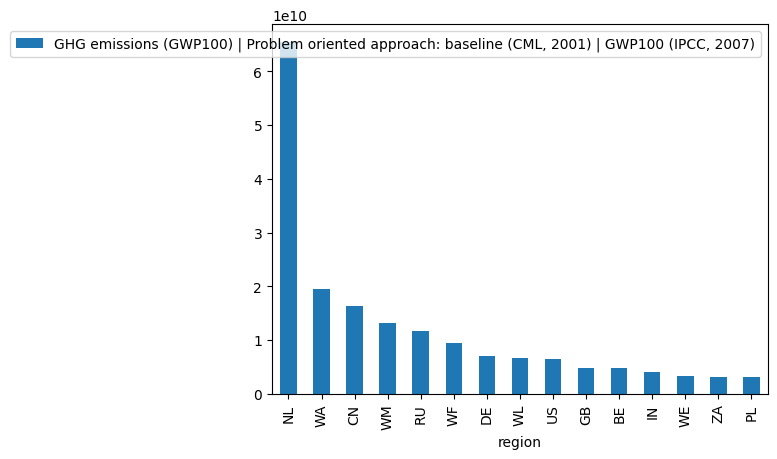

In [20]:
# plot your results with plot.bar()
e_rb_sorted[:15].plot.bar()

#### 6.2 Let's normalize results by the total footprint of NL consumption

<AxesSubplot: xlabel='region'>

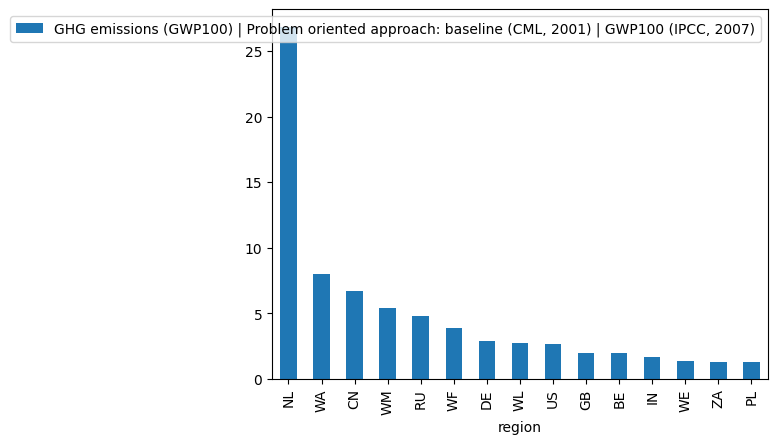

In [21]:
# Normalize your results
e_rb_sorted_norm = e_rb_sorted/e_total*100

# Plot top 15 regions
e_rb_sorted_norm[:15].plot.bar()